In [1]:
import numpy as np
import random
import traci
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

import matplotlib.pyplot as plt
import math

In [2]:
# SUMO configuration
SUMO_BINARY = "sumo-gui"  # or "sumo"
SUMO_CONFIG = "../config/my_simulation.sumocfg"

# Hyperparameters
GAMMA = 1 #0.99
ALPHA = 0.001   # Learning rate
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

REPLAY_BUFFER_SIZE = 10000      # MEMORY_CAPACITY ????
BATCH_SIZE = 32 #64                 
TARGET_UPDATE = 10   # (frequency) Update target network every N episodes

NBR_EPISODES = 100 #500
STEPS_PER_EPISODE = 1000 #3600  # 1 hour in simulation steps

# Initialize environment parameters
STATE_SIZE = 4 #4  # Adjust based on state representation: e.g., (highway_density, ramp_density, ...)
ACTION_SIZE = 2 #3  # Adjust based on action space: e.g., green light durations

## Neural Network architecture
Continuous state space for DQN

In [3]:
# Neural network architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size, batch_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, batch_size)
        # self.fc2 = nn.Linear(batch_size, batch_size)
        self.fc3 = nn.Linear(batch_size, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# # Define the Q-network model
# class QNetwork(nn.Module):
#     def __init__(self, state_dim, action_dim):
#         super(QNetwork, self).__init__()
#         self.fc1 = nn.Linear(state_dim, 32)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(32, action_dim)
        
#     def forward(self, state):
#         x = self.fc1(state)
#         x = self.relu(x)
#         x = self.fc2(x)
#         return x

# # Instantiate the Q-network and target Q-network
# model = QNetwork(state_dim=STATE_SIZE, action_dim=ACTION_SIZE)
# target_model = QNetwork(state_dim=STATE_SIZE, action_dim=ACTION_SIZE)

# # Initialize the target model with the weights of the main model
# target_model.load_state_dict(model.state_dict())

# # Optimizer and loss function
# optimizer = optim.Adam(model.parameters(), lr=ALPHA)
# loss_fn = nn.MSELoss()


In [5]:
# Initialize networks and optimizer
policy_net = DQN(STATE_SIZE, ACTION_SIZE, BATCH_SIZE)
target_net = DQN(STATE_SIZE, ACTION_SIZE, BATCH_SIZE)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=ALPHA)
loss_fn = nn.MSELoss()

# Replay buffer
replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)

In [6]:
def get_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    return math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)

def get_nearest_vehicle_distance(junction_id, edge_id):
    """
    Get the smallest distance between a junction and the nearest vehicle on a specific edge.
    
    Args:
    - junction_id: ID of the junction (e.g., "J11").
    - edge_id: ID of the edge (e.g., "E6").
    
    Returns:
    - Smallest distance to the nearest vehicle or None if no vehicles are on the edge.
    """
    # Get the position of the junction
    junction_position = traci.junction.getPosition(junction_id)
    
    # Get the list of vehicle IDs on the specified edge
    vehicle_ids = traci.edge.getLastStepVehicleIDs(edge_id)
    
    if not vehicle_ids:
        # No vehicles on the edge
        return float('inf')
    
    # Calculate distances from the junction to each vehicle
    distances = []
    for vehicle_id in vehicle_ids:
        vehicle_position = traci.vehicle.getPosition(vehicle_id)
        distance = get_distance(junction_position, vehicle_position)
        distances.append(distance)
    
    # Return the smallest distance
    return min(distances)

In [7]:
# Helper functions
def choose_action(state, epsilon):
    """Epsilon-greedy action selection."""
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, ACTION_SIZE - 1)  # Exploration
    else:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
        return torch.argmax(q_values).item()  # Exploitation
    

def take_action(action):
    """Apply the selected action in SUMO."""
    traci.trafficlight.setPhase("J11", action)
    
    # durations = [10, 20, 30]  # Example action mapping to green light durations
    # traci.trafficlight.setPhaseDuration("J11", durations[action])


def get_state():
    """Retrieve the current state from SUMO."""

    highway_density = traci.edge.getLastStepVehicleNumber("E6")   #sum(traci.lane.getLastStepVehicleNumber(lane) for lane in ["E6_0", "E6_1", "E6_2"])
    ramp_density = traci.edge.getLastStepVehicleNumber("E8")
    junction_density = traci.edge.getLastStepVehicleNumber(":J11_2")

    highway_speed = traci.edge.getLastStepMeanSpeed("E6")   #sum(traci.lane.getLastStepMeanSpeed(lane) for lane in ["E6_0", "E6_1", "E6_2"]) / 3
    ramp_speed = traci.edge.getLastStepMeanSpeed("E8")
    highway_speed = (traci.edge.getLastStepMeanSpeed("E6") + traci.edge.getLastStepMeanSpeed("E7"))
    if highway_density > 0 and traci.edge.getLastStepVehicleNumber("E7") > 0:       
        highway_speed /= 2                                      # Mean

    nearest_distance_highway = get_nearest_vehicle_distance("J11", "E6")
    
    
    state = (junction_density, ramp_density, highway_speed, nearest_distance_highway)
    # state = np.array([highway_density, ramp_density, highway_speed, nearest_distance_highway, junction_density], dtype=np.float32)
    # state = np.array([highway_density, ramp_density, highway_speed, ramp_speed, nearest_distance_highway, junction_density], dtype=np.float32)

    #######################################################
    # state = [
    #     traci.edge.getLastStepHaltingNumber("E6"),
    #     traci.edge.getLastStepHaltingNumber("E8"),
    #     traci.edge.getLastStepMeanSpeed("E6"),
    #     traci.edge.getLastStepMeanSpeed("E8")
    # ]
    #######################################################

    return state


def calculate_reward(state):
    """Calculate reward based on the current state."""
    # highway_density, ramp_density, highway_speed, ramp_speed = state

    #######################################################
    highway_density = traci.edge.getLastStepVehicleNumber("E6")
    ramp_density = traci.edge.getLastStepVehicleNumber("E8")
    highway_speed = traci.edge.getLastStepMeanSpeed("E6")
    ramp_speed = traci.edge.getLastStepMeanSpeed("E8")

    # Collisions & Emergency stopping
    nbr_colliding_vehicles = traci.simulation.getCollidingVehiclesNumber()
    nbr_stopping_vehicles = traci.simulation.getEmergencyStoppingVehiclesNumber()

    # Halting
    highway_halting = traci.edge.getLastStepHaltingNumber("E6")
    ramp_halting = traci.edge.getLastStepHaltingNumber("E8")


    if ramp_density >= 6:
        reward = nbr_colliding_vehicles * -100 + (ramp_density) * -1 + (highway_speed) * 0.2# + (ramp_halting) * -0.1
    else:
        reward = nbr_colliding_vehicles * -100 + (ramp_density) * -0.2 + (highway_speed) * 0.2# + (ramp_halting) * -0.1
    # if ramp_density >= 6:
    #     reward = nbr_colliding_vehicles * -500 + nbr_stopping_vehicles * -100 + (ramp_density) * -1 + (highway_speed) * 0.2
    # else:
    #     reward = nbr_colliding_vehicles * -500 + nbr_stopping_vehicles * -100 + (ramp_density) * -0.4 + (highway_speed) * 0.2

    # reward = nbr_colliding_vehicles * -500 + nbr_stopping_vehicles * -100 + (ramp_density + highway_density) * -0.1 + (highway_speed + ramp_speed) * 0.1
    
    # Get the current traffic light state
    light_state = traci.trafficlight.getRedYellowGreenState("J11")
    if "r" in light_state:  # The ramp phase is red             # Check if the phase is red for ramp traffic
        reward -= 0.02  # Small penalty for a red light phase (adjust the penalty value as needed)


    #######################################################
    # main_road_halting = state[0]
    # ramp_halting = state[1]
    # main_road_speed = state[2]
    # ramp_speed = state[3]
    # reward = -(main_road_halting + ramp_halting) * 0.5 + (main_road_speed + ramp_speed)
    #######################################################

    # reward = - (ramp_density + highway_density)  # Penalize high queue lengths
    
    return reward

In [8]:
# Function to get the current state
def get_state():
    """
    Retrieves the current traffic state for the highway and ramp.
    Returns a dictionary representing the state.
    """
    state = {}
    
    # Highway variables
    highway_edges = ["E6", "E7"]  # Replace with your SUMO edge IDs
    state["highway_density"] = [
        traci.edge.getLastStepVehicleNumber(edge) / traci.edge.getLaneNumber(edge) for edge in highway_edges
    ]  # Vehicles per lane
    state["highway_speed"] = [
        traci.edge.getLastStepMeanSpeed(edge) for edge in highway_edges
    ]  # Average speed per edge
    state["highway_flow"] = [
        traci.edge.getLastStepVehicleNumber(edge) / traci.simulation.getDeltaT() for edge in highway_edges
    ]  # Flow rate (vehicles per second)
    
    # Ramp variables
    ramp_edge = "E8"  # Replace with your SUMO ramp edge ID
    state["ramp_queue_length"] = traci.edge.getLastStepVehicleNumber(ramp_edge)  # Queue length
    state["ramp_speed"] = traci.edge.getLastStepMeanSpeed(ramp_edge)  # Average speed on the ramp
    state["ramp_flow"] = traci.edge.getLastStepVehicleNumber(ramp_edge) / traci.simulation.getDeltaT()  # Ramp flow
    
    # Traffic light phase
    traffic_light_id = "J11"  # Replace with your SUMO traffic light ID
    state["traffic_light_phase"] = traci.trafficlight.getPhase(traffic_light_id)  # 0: red, 1: green
    
    # Time since phase change
    state["time_since_last_phase_change"] = traci.trafficlight.getPhaseDuration(traffic_light_id)
    
    return state

# Function to calculate the reward
def calculate_reward(state):
    """
    Calculates the reward based on the current state.
    """
    # Define weights for reward terms
    alpha = 1.0  # Weight for ramp queue length penalty
    beta = 1.0  # Weight for highway flow penalty
    gamma = 1.0  # Weight for speed reward
    
    # Ramp queue length penalty
    ramp_queue_penalty = -alpha * state["ramp_queue_length"]
    
    # Highway flow penalty (inverse of flow rate; large penalty if flow is zero)
    highway_flow_penalty = -beta * sum(1.0 / max(flow, 1e-3) for flow in state["highway_flow"])
    
    # Speed reward (encourage higher average speeds)
    speed_reward = gamma * (sum(state["highway_speed"]) + state["ramp_speed"])
    
    # Combine rewards
    total_reward = ramp_queue_penalty + highway_flow_penalty + speed_reward
    return total_reward

In [9]:
# def get_state():
#     """Retrieve the current state from SUMO."""

#     highway_density = traci.edge.getLastStepVehicleNumber("E6")   #sum(traci.lane.getLastStepVehicleNumber(lane) for lane in ["E6_0", "E6_1", "E6_2"])
#     ramp_density = traci.edge.getLastStepVehicleNumber("E8")
#     highway_speed = traci.edge.getLastStepMeanSpeed("E6")   #sum(traci.lane.getLastStepMeanSpeed(lane) for lane in ["E6_0", "E6_1", "E6_2"]) / 3
#     ramp_speed = traci.edge.getLastStepMeanSpeed("E8")
#     nearest_distance_highway = get_nearest_vehicle_distance("J11", "E6")
#     junction_density = traci.edge.getLastStepVehicleNumber(":J11_2")

#     highway_speed = (traci.edge.getLastStepMeanSpeed("E6") + traci.edge.getLastStepMeanSpeed("E7"))
#     if highway_density > 0 and traci.edge.getLastStepVehicleNumber("E7") > 0:       
#         highway_speed /= 2                                      # Mean
    
#     state = (junction_density, ramp_density, highway_speed)

#     return state


# def calculate_reward(state):
#     """Calculate reward based on the current state."""
#     # highway_density, ramp_density, highway_speed, ramp_speed = state

#     highway_density = traci.edge.getLastStepVehicleNumber("E6")
#     ramp_density = traci.edge.getLastStepVehicleNumber("E8")
#     highway_speed = traci.edge.getLastStepMeanSpeed("E6")
#     ramp_speed = traci.edge.getLastStepMeanSpeed("E8")

#     # Collisions & Emergency stopping
#     nbr_colliding_vehicles = traci.simulation.getCollidingVehiclesNumber()
#     nbr_stopping_vehicles = traci.simulation.getEmergencyStoppingVehiclesNumber()


#     if ramp_density >= 6:
#         reward = nbr_colliding_vehicles * -100 + (ramp_density) * -1 + (highway_speed) * 0.2
#     else:
#         reward = nbr_colliding_vehicles * -100 + (ramp_density) * -0.2 + (highway_speed) * 0.2    
    
#     # Get the current traffic light state
#     light_state = traci.trafficlight.getRedYellowGreenState("J11")
#     if "r" in light_state:  # The ramp phase is red             # Check if the phase is red for ramp traffic
#         reward -= 0.05  # Small penalty for a red light phase (adjust the penalty value as needed)
    
#     return reward

In [10]:
def train():
    """Train the DQN using replay buffer."""
    if len(replay_buffer) < BATCH_SIZE:
        return
    
    # Sample mini-batch from replay buffer
    batch = random.sample(replay_buffer, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32)

    # Q(s, a) and max_a' Q'(s', a')
    q_values = policy_net(states).gather(1, actions).squeeze()
    next_q_values = target_net(next_states).max(1)[0]
    target_q_values = rewards + GAMMA * next_q_values * (1 - dones)

    # Loss and optimization
    loss = loss_fn(q_values, target_q_values.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# Main training loop
episode_rewards = [] 
epsilon = 0.1 #EPSILON_START

traci.start([SUMO_BINARY, "-c", SUMO_CONFIG])
for episode in range(NBR_EPISODES):
    # traci.start([SUMO_BINARY, "-c", SUMO_CONFIG])
    state = get_state()
    total_reward = 0
    
    for step in range(STEPS_PER_EPISODE):
        # Choose & Take action A
        action = choose_action(state, epsilon)
        take_action(action)
        traci.simulationStep()
        
        # Observe S' & R
        next_state = get_state()
        reward = calculate_reward(next_state)
        done = (step == STEPS_PER_EPISODE - 1)  # End of episode
        
        # Store transition in replay buffer
        replay_buffer.append((state, action, reward, next_state, done))
        
        # Train the policy network
        train()
        
        state = next_state
        total_reward += reward
    
    # Update epsilon
    # epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    
    
    episode_rewards.append(total_reward)  # Append the total reward for the episode to the list
    

    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    # traci.close()
    
traci.close()


TypeError: float() argument must be a string or a number, not 'list'

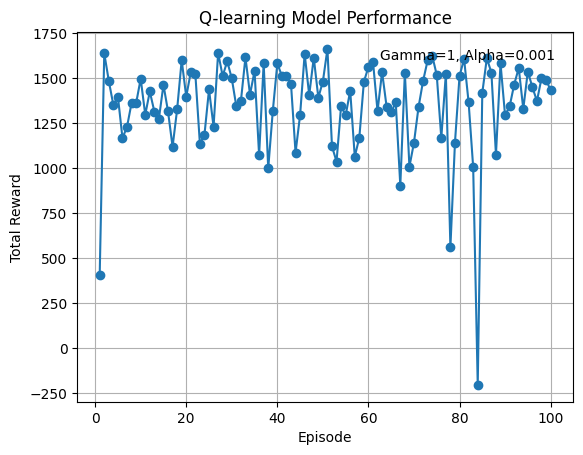

In [ ]:
# Plot the episode rewards
plt.plot(range(1, NBR_EPISODES + 1), episode_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-learning Model Performance')
plt.grid(True)
# Add a legend with hyperparameter values
hyperparams_text = f'Gamma={GAMMA}, Alpha={ALPHA}'#, Epsilon={EPSILON}'
plt.text(NBR_EPISODES + 1, max(episode_rewards), hyperparams_text, ha='right', va='top', fontsize=10)

plt.show()